# Определение перспективного тарифа для телеком компании

Имеем данные 500 пользователей тарифов смарт и ультра компании Мегалайн. В них содержится кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год.Необходимо обработать входящие фреймы , проанализировать данные и проверить требуемые теории. Для этого выполним следующие шаги :  
1) Откроем файлы и посмотрим их содержимое.    
2)Подготовим данные к последующей обработке (проверка на отсутсвие данных, правильность типы данных в столбцах и возможно еще что-то прийдет в голову по мере выполнения )    
3)Посчитаем следующие показатели по месяцам : израсходованные минуты разговора, количество отправленных сообщений по месяцам, интернет-трафик, выручка с каждого пользователя.  
4) Провести анализ необходимого количества основных показателей для каждого тарифа в месяц.(среднее количество, дисперсию и стандартное отклонение, для наглядности построить гистограммы.)
5) Проверим гипотезы    что  средняя выручка пользователей тарифов «Ультра» и «Смарт» различается;
    средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов;  
    

Наименования столбцов и их значения:  
Таблица users (информация о пользователях):

    user_id — уникальный идентификатор пользователя
    first_name — имя пользователя
    last_name — фамилия пользователя
    age — возраст пользователя (годы)
    reg_date — дата подключения тарифа (день, месяц, год)
    churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
    city — город проживания пользователя
    tariff — название тарифного плана

Таблица calls (информация о звонках):

    id — уникальный номер звонка
    call_date — дата звонка
    duration — длительность звонка в минутах
    user_id — идентификатор пользователя, сделавшего звонок

Таблица messages (информация о сообщениях):

    id — уникальный номер сообщения
    message_date — дата сообщения
    user_id — идентификатор пользователя, отправившего сообщение

Таблица internet (информация об интернет-сессиях):

    id — уникальный номер сессии
    mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
    session_date — дата интернет-сессии
    user_id — идентификатор пользователя

Таблица tariffs (информация о тарифах):

    tariff_name — название тарифа
    rub_monthly_fee — ежемесячная абонентская плата в рублях
    minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
    messages_included — количество сообщений в месяц, включённых в абонентскую плату
    mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
    rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
    rub_per_message — стоимость отправки сообщения сверх тарифного пакета
    rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

In [1]:
import pandas as pd
import math as mt
import numpy as np
from scipy import stats as st
import matplotlib.pyplot as plt

In [2]:
data_calls = pd.read_csv('/datasets/calls.csv')
data_internet = pd.read_csv('/datasets/internet.csv')
data_messages = pd.read_csv('/datasets/messages.csv')
data_tariffs = pd.read_csv('/datasets/tariffs.csv')
data_users = pd.read_csv('/datasets/users.csv')


In [3]:
data_calls.head(10)

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000
5,1000_5,2018-11-02,0.00,1000
6,1000_6,2018-10-18,0.00,1000
7,1000_7,2018-08-22,18.31,1000
8,1000_8,2018-09-15,18.44,1000
9,1000_9,2018-08-15,0.00,1000


In [4]:
data_internet.head(10)

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000
5,1000_5,399.97,2018-10-02,1000
6,1000_6,540.08,2018-09-07,1000
7,1000_7,415.70,2018-07-11,1000
8,1000_8,505.40,2018-10-08,1000
9,1000_9,345.54,2018-09-03,1000


In [5]:
data_messages.head(10)

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000
5,1000_5,2018-06-20,1000
6,1000_6,2018-11-19,1000
7,1000_7,2018-10-29,1000
8,1000_8,2018-06-25,1000
9,1000_9,2018-12-18,1000


In [6]:
data_tariffs.head(10)

,messages_included,mg_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [7]:
data_users.head(10)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
5,1005,67,NaN,Набережные Челны,Афанасий,Горлов,2018-01-25,smart
6,1006,21,NaN,Ульяновск,Леонид,Ермолаев,2018-02-26,smart
7,1007,65,NaN,Москва,Юна,Березина,2018-04-19,smart
8,1008,63,NaN,Челябинск,Рустэм,Пономарёв,2018-12-19,smart
9,1009,24,NaN,Пермь,Василиса,Блинова,2018-03-22,smart


In [8]:
data_calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


In [9]:
data_internet.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 4 columns):
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.6+ MB


In [10]:
data_messages.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


In [11]:
data_tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mg_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


In [12]:
data_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


Перейдем к обработке имеющихся данных. По типу данных - во всех столбцах содержащие даты не верный формат (object будем преобразовывать в формат дата/время), в столбце с длительностью звонков нет необходимости в десятичных числах (переведем в целые с округлением в большую сторону согласно с политикой компании по взымании платы). В данных содержащих в себе информацию по использованнном трафику значения в мегабайтах, для дальнейшей работы переведем их в гигбайты и округлим в большую сторону (плата взимается за каждый гиг сверх тарифа , если будут значения близкие к максимуму входящие в пакет это не навредит им), но сначала сгруппируем их и проссумируем для каждого клиента(вот без этого будет ошибка)

Преобразуем столбцы содержащие в себе даты 

In [13]:
def date_changer(data,column):
    data[column] = pd.to_datetime(data[column])

In [14]:
date_changer(data_calls,'call_date')
date_changer(data_internet,'session_date')
date_changer(data_messages,'message_date')
date_changer(data_users,'reg_date')
date_changer(data_users,'churn_date')

Округление минут в большую сторону и преобразование в целочисленный формат

In [15]:
data_calls['duration'] = np.ceil(data_calls['duration'])
data_calls['duration'] = data_calls['duration'].astype('int')
data_calls.info()
#data_calls

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null datetime64[ns]
duration     202607 non-null int64
user_id      202607 non-null int64
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 6.2+ MB


В столбце длительностью звонков много значений равных 0, возможно звонок был на столько краткосрочным , что аппаратура компании не внесла его  длительность в базу(скорее всего недостаток со стороны компании), но раз внесено - значит контакт абонентов имел место  быть, следовательно по правилам описаным в тз даже кроткосрочный звонок считаем за 1 минуту.(в теории конечно, но более разумного объяснения я не вижу, т.к. это фрейм именно со звонками , а не попытками дозвониться)

In [16]:
data_calls.loc[data_calls['duration'] == 0, 'duration'] = 1
#data_calls

Добавим для каждой строки во всех фреймах месяц, когда происходила та или иная деятельность клиентов

In [17]:
def month_adder(data,column):
    data['month'] = data[column].dt.month

In [18]:
month_adder(data_calls,'call_date')
month_adder(data_internet,'session_date')
month_adder(data_messages,'message_date')

Сгруппируем все таблицы по клиенту и месяцу обслуживания

In [19]:
data_calls_dur = data_calls.groupby(['user_id','month'])['duration'].sum()
data_calls_count = data_calls.groupby(['user_id','month'])['duration'].count()
#data_calls_dur

In [20]:
data_messages_count = data_messages.groupby(['user_id','month'])['message_date'].count()
#data_messages_group

In [21]:
data_internet_amount = data_internet.groupby(['user_id','month'])['mb_used'].sum()
#data_internet_amount

In [22]:
data_internet_amount = data_internet_amount / 1024
data_internet_amount = np.ceil(data_internet_amount)
data_tariffs['gb_per_month_included'] = data_tariffs['mg_per_month_included'] / 1024
data_tariffs

,messages_included,mg_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name,gb_per_month_included
0,50,15360,500,550,200,3,3,smart,15.0
1,1000,30720,3000,1950,150,1,1,ultra,30.0


In [23]:
data_tariffs_user = data_users[['user_id','tariff']]

Создадим для удобства фрейм который будет содержать все посчитанные выше данные  и добавим в него столбец помесячной выручки

In [24]:
result_frame = pd.concat([data_calls_dur, data_calls_count, data_messages_count, data_internet_amount], axis=1)
columns_name = ['calls_dur', 'calls_count','messages_count', 'gb_used']
result_frame.columns = columns_name
result_frame = result_frame.fillna(0)
result_frame.reset_index (inplace = True)
result_frame = pd.merge(left = result_frame, right = data_tariffs_user, how = 'left', left_on = ['user_id'], right_on = ['user_id'])
result_frame.head(10)


,user_id,month,calls_dur,calls_count,messages_count,gb_used,tariff
0,1000,5,164.0,22.0,22.0,3.0,ultra
1,1000,6,187.0,43.0,60.0,23.0,ultra
2,1000,7,346.0,47.0,75.0,14.0,ultra
3,1000,8,418.0,52.0,81.0,14.0,ultra
4,1000,9,478.0,58.0,57.0,15.0,ultra
5,1000,10,363.0,57.0,73.0,15.0,ultra
6,1000,11,344.0,43.0,58.0,15.0,ultra
7,1000,12,341.0,46.0,70.0,10.0,ultra
8,1001,11,444.0,59.0,0.0,18.0,smart
9,1001,12,430.0,63.0,0.0,14.0,smart


Посчитаем помесячную выручку с каждого клиента (отдельно для каждого показателя смс, звонки и интернет, после проссумируем)

In [25]:
def get_overpayment_calls(row):
    tariff = row[0]
    minutes = row[1]
    if tariff == 'smart':
        if (minutes - 500) < 0:
            return 0
        else:
            return abs(minutes - 500)* 3
   
    else:
        if (minutes - 3000) < 0:
            return 0
        else:
            return abs(minutes - 3000)

In [26]:
result_frame['calls_overpayment'] = result_frame[['tariff','calls_dur']].apply(get_overpayment_calls, axis = 1)
#result_frame['calls_overpayment'].unique()

In [27]:
def get_overpayment_internet(row):
    tariff = row[0]
    internet_gb = row[1]
    if tariff == 'smart':
        if (internet_gb - 15) < 0:
            return 0
        else:
            return abs(internet_gb - 15)* 200
   
    else:
        if (internet_gb - 30) < 0:
            return 0
        else:
            return abs(internet_gb - 30)* 150

In [28]:
result_frame['internet_overpayment'] = result_frame[['tariff','gb_used']].apply(get_overpayment_internet, axis = 1)

In [29]:
def get_overpayment_messages(row):
    tariff = row[0]
    sms_count = row[1]
    if tariff == 'smart':
        if (sms_count - 50) < 0:
            return 0
        else:
            return abs(sms_count - 50)* 3
   
    else:
        if (sms_count - 1000) < 0:
            return 0
        else:
            return abs(sms_count - 1000)

In [30]:
result_frame['messages_overpayment'] = result_frame[['tariff','messages_count']].apply(get_overpayment_messages, axis = 1)

In [31]:
result_frame

,user_id,month,calls_dur,calls_count,messages_count,gb_used,tariff,calls_overpayment,internet_overpayment,messages_overpayment
0,1000,5,164.0,22.0,22.0,3.0,ultra,0.0,0.0,0.0
1,1000,6,187.0,43.0,60.0,23.0,ultra,0.0,0.0,0.0
2,1000,7,346.0,47.0,75.0,14.0,ultra,0.0,0.0,0.0
3,1000,8,418.0,52.0,81.0,14.0,ultra,0.0,0.0,0.0
4,1000,9,478.0,58.0,57.0,15.0,ultra,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
3209,1498,10,258.0,41.0,42.0,21.0,smart,0.0,1200.0,0.0
3210,1499,9,71.0,9.0,11.0,2.0,smart,0.0,0.0,0.0
3211,1499,10,473.0,68.0,48.0,18.0,smart,0.0,600.0,0.0
3212,1499,11,624.0,74.0,59.0,18.0,smart,372.0,600.0,27.0


In [32]:
#result_frame['revenue'] = result_frame['calls_overpayment'] + result_frame['internet_overpayment'] + result_frame['messages_overpayment']
def get_revenue(row):
    tariff = row[0]
    messages_overpayment = row[1]
    internet_overpayment = row[2]
    calls_overpayment = row[3]
    if tariff == 'smart':
        return (messages_overpayment + internet_overpayment + calls_overpayment + 550)
    else:
        return (messages_overpayment + internet_overpayment + calls_overpayment + 1950)

In [33]:
result_frame['revenue'] = result_frame[['tariff','messages_overpayment', 'internet_overpayment', 'calls_overpayment']].apply(get_revenue, axis = 1)
#result_frame

 Имеем фрейм с основными параметрами по каждому пользователю тарифа, используя полученные данные посчитаем среднее , дисперсию и стандартное отклонение для количества,минут,сообщений и интернета в месяц для каждого клиента. Также построим гистограммы.

In [34]:
mean_values = result_frame.groupby(['user_id'])[['calls_dur','messages_count', 'gb_used']].mean()
mean_values
#data_internet_amount = data_internet.groupby(['user_id','month'])['mb_used'].sum()

,calls_dur,messages_count,gb_used
user_id,,,
1000,330.125000,62.0,13.625000
1001,437.000000,0.0,16.000000
1002,223.000000,10.0,16.714286
1003,782.800000,76.0,11.800000
1004,128.000000,149.0,18.750000
...,...,...,...
1495,803.800000,68.0,25.400000
1496,512.083333,39.0,22.500000
1497,483.666667,17.0,15.333333


Дисперсия

In [35]:
variance = np.var(mean_values, ddof=1)
variance

calls_dur         42844.632882
messages_count     1227.815393
gb_used              30.344784
dtype: float64

Стандартное отклонение

In [36]:
standard_deviation = np.std(mean_values, ddof=1)
standard_deviation

calls_dur         206.989451
messages_count     35.040197
gb_used             5.508610
dtype: float64

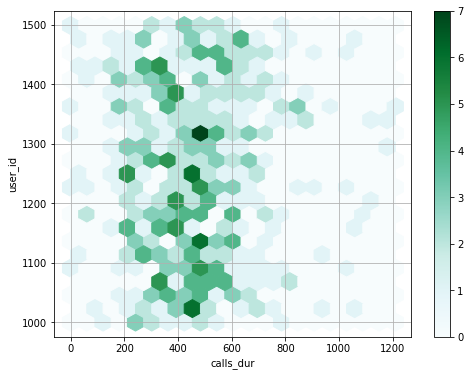

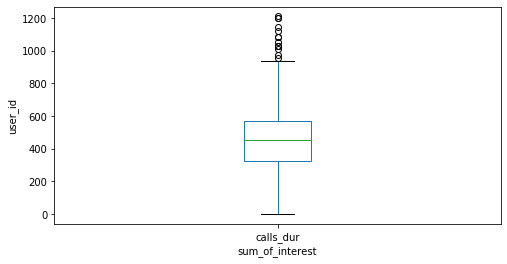

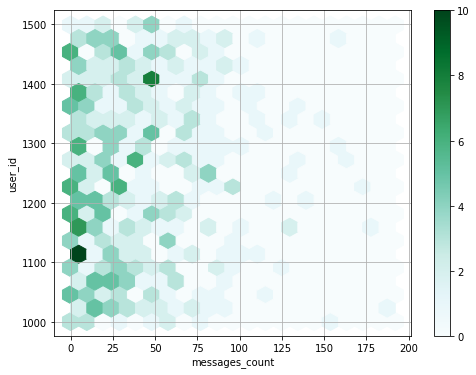

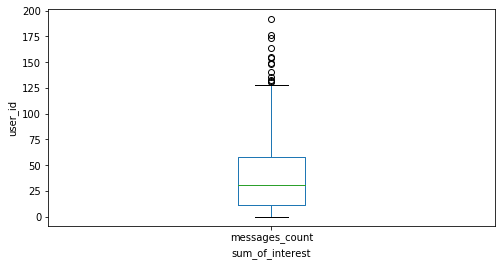

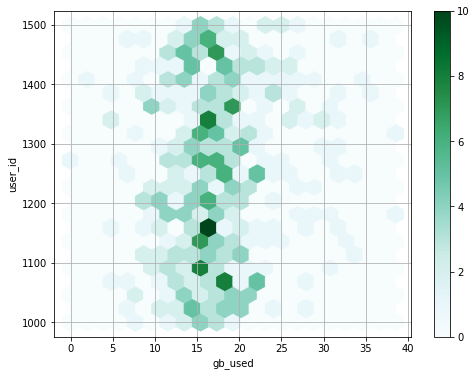

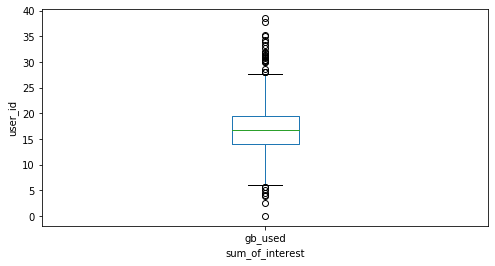

In [37]:
mean_values.reset_index (inplace = True)
hist_list = ['calls_dur','messages_count','gb_used']
for element in hist_list:
    mean_values.plot( x = element ,y = 'user_id',kind='hexbin', gridsize=20, figsize=(8, 6), sharex=False, grid=True)
    fig = plt.figure(figsize = (8,4))
    plt.xlabel('sum_of_interest')
    plt.ylabel('user_id')
    mean_values[element].plot.box(subplots=False,sharex=False,sharey=False)
#mean_values.plot( x = 'calls_dur' ,y = 'user_id',kind='hexbin', gridsize=20, figsize=(8, 6), sharex=False, grid=True)

Для наглядности распределения средне использованных минут, сообщений и гигабайт интернета были построены графики. В среднем проговаривают около 400 минут, сообщений используют довольно мало 25-50, график с использованными гигабайтами самой показательный большая часть показателей между 15 и 20 гигабайтами.

Имее две гипотезы на проверку :  
    средняя выручка пользователей тарифов «Ультра» и «Смарт» различается;  
    средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов;  
Для первой гипотезы :     
Ее формулировка подойдет для нулевой гипотезы H₀ , альтернативная гипотеза средняя выручка пользователей тарифов «Ультра» и «Смарт» не различается.  
Аналогично для второй гипотезы :  
Альтернативная будет звучать средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов. 
Перед проверкой гипотез нужно подготовить совокупности.

In [38]:
mean_revenue = result_frame.groupby(['user_id'])['revenue'].mean().reset_index()
mean_revenue_tariffs = pd.merge(left = mean_revenue, right = data_tariffs_user, how = 'left', left_on = ['user_id'], right_on = ['user_id'])
data_users_city = data_users[['user_id','city']]
mean_revenue_city =  pd.merge(left = mean_revenue, right = data_users_city, how = 'left', left_on = ['user_id'], right_on = ['user_id'])
mean_revenue_tariffs

,user_id,revenue,tariff
0,1000,1950.000000,ultra
1,1001,850.000000,smart
2,1002,1035.714286,smart
3,1003,1950.000000,ultra
4,1004,1950.000000,ultra
...,...,...,...
493,1495,2310.000000,ultra
494,1496,2392.833333,smart
495,1497,947.333333,smart
496,1498,1659.000000,smart


Приступим к проверке гипотез

In [39]:
query_smart = mean_revenue_tariffs.query('tariff == "smart"')
query_ultra  = mean_revenue_tariffs.query('tariff == "ultra"')


In [40]:
smart = np.array(query_smart['revenue'].tolist())
ultra = np.array(query_ultra['revenue'].tolist())

In [41]:
results = st.ttest_ind(smart, ultra)
alpha = 0.05
print('p-значение:', results.pvalue)
if (results.pvalue < alpha): 
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 4.5896384702074343e-38
Отвергаем нулевую гипотезу


В результате расчетов получили, что  отвергаем нулевую теорию, т.е. средняя  дополнительная выручка сверх платы за тариф пользователей тарифов «Ультра» и «Смарт» различается(значение p очень мало значит данные результаты почти не получить случайно).   
Перейдем ко второй гипотезе.

In [42]:
query_moscow = mean_revenue_city.query('city == "Москва"')
query_other = mean_revenue_city.query('city != "Москва"')
moscow = np.array(query_moscow['revenue'].tolist())
other = np.array(query_other['revenue'].tolist())

In [43]:
results = st.ttest_ind(moscow, other)
alpha = 0.05
print('p-значение:', results.pvalue)
if (results.pvalue < alpha): 
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.35231667345149364
Не получилось отвергнуть нулевую гипотезу


Гипотеза не опровергается т.е. средняя дополнительная выручка сверх платы за тариф пользователей Москвы и остальных городов не различается (значение p показывает что с вероятностью почти в 35 % такое различие можно получить случайно)

In [44]:
query_smart = mean_revenue_tariffs.query('tariff == "smart"')
query_ultra  = mean_revenue_tariffs.query('tariff == "ultra"')
print('Средняя выручка с клиента с тарифом смарт ', query_smart['revenue'].mean() )
print('Средняя выручка с клиента с тарифом ультра ', query_ultra['revenue'].mean())

Средняя выручка с клиента с тарифом смарт  1341.5799373325087
Средняя выручка с клиента с тарифом ультра  2086.4646586521585


### Вывод

Был изучен и обработан входящий фрейм. Отсутствующие данные в столбце содержащий в себе длительность звонков были заменены. 
Были посчитаны и добавлены дополнительные фреймы : помесячная выручка с каждого пользователя, средняя выручка с клиента за рассмотренный период. Расчитаны дисперсия и среднеквадратичное отклонения для выручки с каждого клиента и построены графики распределения выручки по каждому доходному пункту (за смс, звонки и интернет)  
Были проверены две гипотезы поставленные в задании и как итог :  
cредняя дополнительная выручка сверх платы за тариф пользователей тарифов «Ультра» и «Смарт» различается  
средняя дополнительная выручка сверх платы за тариф пользователей Москвы и остальных городов не различается  
Основной целью было выяснить какой тариф все же выгоднее для компании и не смотря на то что, пользователи тарифа смарт в среднем тратят сверх тарифа в несколько раз больше денег чем пользователи тарифа ультра, если рассматривать приход компании с учетом ежемесячного платежа тариф ультра будет более прибыльным (2086 руб в месяц против 1341 от смарта разница порядка 35%)
